__Importing Libraries__

In [1]:
from pathlib import Path
import sys 
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.metrics import roc_curve, auc
import lightgbm
import optuna
from optuna.samplers import TPESampler
from lightgbm import log_evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly


__Importing CSV files__

In [2]:
flattened_officer_data = pd.read_csv('../data/officer_features_dataset.csv')
data_modelling = pd.read_csv("../data/modelling_officer_dataset.csv")
data_backtest = pd.read_csv("../data/backtesting_officer_dataset.csv")

/var/folders/c2/zbmcqxr93qq5t5w36fn3n3cr0000gn/T/ipykernel_10282/2859199390.py:1: DtypeWarning: Columns (615,616,617,618) have mixed types. Specify dtype option on import or set low_memory=False.
  flattened_officer_data = pd.read_csv('../data/officer_features_dataset.csv')
/var/folders/c2/zbmcqxr93qq5t5w36fn3n3cr0000gn/T/ipykernel_10282/2859199390.py:2: DtypeWarning: Columns (615,616,617,618) have mixed types. Specify dtype option on import or set low_memory=False.
  data_modelling = pd.read_csv("../data/modelling_officer_dataset.csv")
/var/folders/c2/zbmcqxr93qq5t5w36fn3n3cr0000gn/T/ipykernel_10282/2859199390.py:3: DtypeWarning: Columns (615,616,617,618) have mixed types. Specify dtype option on import or set low_memory=False.
  data_backtest = pd.read_csv("../data/backtesting_officer_dataset.csv")


In [3]:
flattened_officer_data

officer_number   
0     2320459b9764dd74c84ac18cc3dae6729cb76767  \
1     1816c2575deb9e44d8ed129592ddb694ae2aa9c6   
2     b30185688bf32a5a113d1a8d3ce15b2ae22449a8   
3     40c983af1a4c7f62231eb8c42036068fd412de00   
4     6be36a3be738d0058566fd6a1993a52c02f7be2b   
...                                        ...   
6988  44fb2190750c31a203f7ddb291ea12f9f196d8cc   
6989  24684a7fb902fabe5cdcf776bab1d74ea2180bf4   
6990  a5705feef6e3031e3bb9ce145b45b6c6240bc3ea   
6991  19fd0fc0d3aebb69f52706e087302499073f9d17   
6992  484bdbcc06cc693d2b34e392fd8ab742f258ad71   

      filings_sum_appt_GAZ1(A)_0_months  filings_sum_appt_GAZ1(A)_3_months   
0                                   0.0                                0.0  \
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   NaN                                NaN   
4                                   0.0                                0.0   
...                                 ...                                ...   
6988                                NaN                                NaN   
6989                                0.0                                1.0   
6990                                0.0                                0.0   
6991                                0.0                                0.0   
6992                                NaN                                NaN   

      filings_sum_appt_GAZ1(A)_6_months  filings_sum_appt_GAZ1(A)_12_months   
0                                   0.0                                 0.0  \
1                                   0.0                                 1.0   
2                                   0.0                                 0.0   
3                                   NaN                                 NaN   
4                                   0.0                                 0.0   
...                                 ...                                 ...   
6988                                NaN                                 NaN   
6989                                1.0                                 1.0   
6990                                2.0                                 2.0   
6991                                0.0                                 0.0   
6992                                NaN                                 NaN   

      filings_sum_appt_GAZ1(A)_24_months  filings_sum_appt_GAZ1(A)_36_months   
0                                    0.0                                 0.0  \
1                                    2.0                                 2.0   
2                                    0.0                                 0.0   
3                                    NaN                                 NaN   
4                                    1.0                                 1.0   
...                                  ...                                 ...   
6988                                 NaN                                 NaN   
6989                                 1.0                                 3.0   
6990                                 2.0                                 2.0   
6991                                 1.0                                 2.0   
6992                                 NaN                                 NaN   

      filings_sum_appt_GAZ1(A)_all_months   
0                                     1.0  \
1                                    18.0   
2                                     1.0   
3                                     NaN   
4                                     1.0   
...                                   ...   
6988                                  NaN   
6989                                 19.0   
6990                                  5.0   
6991                                 10.0   
6992                                  NaN   

      filings_sum_appt_RESOLUTIONS_0_months

__Fixing columns with multiple datatypes in the modelling and backtest datasets__

In [4]:
flattened_officer_data.replace([np.inf, -np.inf], np.nan, inplace=True)

flattened_officer_data["officer_min_officer_age_at_appointment"] = flattened_officer_data["officer_min_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
flattened_officer_data["officer_mean_officer_age_at_appointment"] =flattened_officer_data["officer_mean_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
flattened_officer_data["officer_median_officer_age_at_appointment"] = flattened_officer_data["officer_median_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
flattened_officer_data["officer_max_officer_age_at_appointment"] = flattened_officer_data["officer_max_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
flattened_officer_data['nationality'] = flattened_officer_data['nationality'].astype('str')


In [5]:
data_modelling.replace([np.inf, -np.inf], np.nan, inplace=True)

data_modelling["officer_min_officer_age_at_appointment"] = data_modelling["officer_min_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_modelling["officer_mean_officer_age_at_appointment"] =data_modelling["officer_mean_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_modelling["officer_median_officer_age_at_appointment"] = data_modelling["officer_median_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_modelling["officer_max_officer_age_at_appointment"] = data_modelling["officer_max_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_modelling['nationality'] = data_modelling['nationality'].astype('str')


In [6]:
data_backtest.replace([np.inf, -np.inf], np.nan, inplace=True)

data_backtest["officer_min_officer_age_at_appointment"] = data_backtest["officer_min_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_backtest["officer_mean_officer_age_at_appointment"] =data_backtest["officer_mean_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_backtest["officer_median_officer_age_at_appointment"] = data_backtest["officer_median_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_backtest["officer_max_officer_age_at_appointment"] = data_backtest["officer_max_officer_age_at_appointment"].apply(lambda age : np.nan if age=='unknown' else float(age))
data_backtest['nationality'] = data_backtest['nationality'].astype('str')


In [7]:
columns_with_gaz1 = [col for col in data_modelling.columns if 'GAZ1' in col]
columns_with_gaz1
data_modelling[columns_with_gaz1] = data_modelling[columns_with_gaz1].fillna(0)
data_backtest[columns_with_gaz1] = data_backtest[columns_with_gaz1].fillna(0)
flattened_officer_data[columns_with_gaz1] = flattened_officer_data[columns_with_gaz1].fillna(0)

In [8]:
flattened_officer_data

officer_number   
0     2320459b9764dd74c84ac18cc3dae6729cb76767  \
1     1816c2575deb9e44d8ed129592ddb694ae2aa9c6   
2     b30185688bf32a5a113d1a8d3ce15b2ae22449a8   
3     40c983af1a4c7f62231eb8c42036068fd412de00   
4     6be36a3be738d0058566fd6a1993a52c02f7be2b   
...                                        ...   
6988  44fb2190750c31a203f7ddb291ea12f9f196d8cc   
6989  24684a7fb902fabe5cdcf776bab1d74ea2180bf4   
6990  a5705feef6e3031e3bb9ce145b45b6c6240bc3ea   
6991  19fd0fc0d3aebb69f52706e087302499073f9d17   
6992  484bdbcc06cc693d2b34e392fd8ab742f258ad71   

      filings_sum_appt_GAZ1(A)_0_months  filings_sum_appt_GAZ1(A)_3_months   
0                                   0.0                                0.0  \
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   0.0                                0.0   
4                                   0.0                                0.0   
...                                 ...                                ...   
6988                                0.0                                0.0   
6989                                0.0                                1.0   
6990                                0.0                                0.0   
6991                                0.0                                0.0   
6992                                0.0                                0.0   

      filings_sum_appt_GAZ1(A)_6_months  filings_sum_appt_GAZ1(A)_12_months   
0                                   0.0                                 0.0  \
1                                   0.0                                 1.0   
2                                   0.0                                 0.0   
3                                   0.0                                 0.0   
4                                   0.0                                 0.0   
...                                 ...                                 ...   
6988                                0.0                                 0.0   
6989                                1.0                                 1.0   
6990                                2.0                                 2.0   
6991                                0.0                                 0.0   
6992                                0.0                                 0.0   

      filings_sum_appt_GAZ1(A)_24_months  filings_sum_appt_GAZ1(A)_36_months   
0                                    0.0                                 0.0  \
1                                    2.0                                 2.0   
2                                    0.0                                 0.0   
3                                    0.0                                 0.0   
4                                    1.0                                 1.0   
...                                  ...                                 ...   
6988                                 0.0                                 0.0   
6989                                 1.0                                 3.0   
6990                                 2.0                                 2.0   
6991                                 1.0                                 2.0   
6992                                 0.0                                 0.0   

      filings_sum_appt_GAZ1(A)_all_months   
0                                     1.0  \
1                                    18.0   
2                                     1.0   
3                                     0.0   
4                                     1.0   
...                                   ...   
6988                                  0.0   
6989                                 19.0   
6990                                  5.0   
6991                                 10.0   
6992                                  0.0   

      filings_sum_appt_RESOLUTIONS_0_months

In [9]:
data_modelling

officer_number   
0     472795bd2d0c4e3e00c3fc33740bdfa894cfa55b  \
1     092c6bc880957f7a9351c43bef9b6f22e1a2fbe8   
2     d581900a4614b0f950d0f75dc6f3845a0052129b   
3     208fa76aa1a97053dbf03758d57a1fa245f54698   
4     e819fdb1c36d9231308495bceb1f4067fcaefc9a   
...                                        ...   
5930  40c983af1a4c7f62231eb8c42036068fd412de00   
5931  1816c2575deb9e44d8ed129592ddb694ae2aa9c6   
5932  27bbbb15d67b9593567c5fa2476550db5e3cc8db   
5933  e1b046bff7879f8ff7c4078769e44fc4dc748bde   
5934  2320459b9764dd74c84ac18cc3dae6729cb76767   

      filings_sum_appt_GAZ1(A)_0_months  filings_sum_appt_GAZ1(A)_3_months   
0                                   0.0                                0.0  \
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   0.0                                0.0   
4                                   0.0                                0.0   
...                                 ...                                ...   
5930                                0.0                                0.0   
5931                                0.0                                0.0   
5932                                0.0                                0.0   
5933                                0.0                                0.0   
5934                                0.0                                0.0   

      filings_sum_appt_GAZ1(A)_6_months  filings_sum_appt_GAZ1(A)_12_months   
0                                   0.0                                 0.0  \
1                                   0.0                                 0.0   
2                                   0.0                                 0.0   
3                                   0.0                                 0.0   
4                                   0.0                                 0.0   
...                                 ...                                 ...   
5930                                0.0                                 0.0   
5931                                0.0                                 1.0   
5932                                0.0                                 0.0   
5933                                0.0                                 0.0   
5934                                0.0                                 0.0   

      filings_sum_appt_GAZ1(A)_24_months  filings_sum_appt_GAZ1(A)_36_months   
0                                    0.0                                 0.0  \
1                                    0.0                                 0.0   
2                                    0.0                                 0.0   
3                                    0.0                                 0.0   
4                                    0.0                                 0.0   
...                                  ...                                 ...   
5930                                 0.0                                 0.0   
5931                                 2.0                                 2.0   
5932                                 0.0                                 1.0   
5933                                 0.0                                 0.0   
5934                                 0.0                                 0.0   

      filings_sum_appt_GAZ1(A)_all_months   
0                                     0.0  \
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
...                                   ...   
5930                                  0.0   
5931                                 18.0   
5932                                  1.0   
5933                                  0.0   
5934                                  1.0   

      filings_sum_appt_RESOLUTIONS_0_months

__Computing the Gini coefficient, Abs Gini Coefficient anf NaN rate for all values in the flattened_officer_data csv file__

In [10]:
flattened_officer_data = flattened_officer_data.dropna(subset=['label'])


In [11]:
flattened_officer_data

officer_number   
0     2320459b9764dd74c84ac18cc3dae6729cb76767  \
1     1816c2575deb9e44d8ed129592ddb694ae2aa9c6   
2     b30185688bf32a5a113d1a8d3ce15b2ae22449a8   
3     40c983af1a4c7f62231eb8c42036068fd412de00   
4     6be36a3be738d0058566fd6a1993a52c02f7be2b   
...                                        ...   
6987  9a20fcd96e81ed0f1d1659641f36a9d7966045a6   
6988  44fb2190750c31a203f7ddb291ea12f9f196d8cc   
6989  24684a7fb902fabe5cdcf776bab1d74ea2180bf4   
6990  a5705feef6e3031e3bb9ce145b45b6c6240bc3ea   
6991  19fd0fc0d3aebb69f52706e087302499073f9d17   

      filings_sum_appt_GAZ1(A)_0_months  filings_sum_appt_GAZ1(A)_3_months   
0                                   0.0                                0.0  \
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   0.0                                0.0   
4                                   0.0                                0.0   
...                                 ...                                ...   
6987                                0.0                                0.0   
6988                                0.0                                0.0   
6989                                0.0                                1.0   
6990                                0.0                                0.0   
6991                                0.0                                0.0   

      filings_sum_appt_GAZ1(A)_6_months  filings_sum_appt_GAZ1(A)_12_months   
0                                   0.0                                 0.0  \
1                                   0.0                                 1.0   
2                                   0.0                                 0.0   
3                                   0.0                                 0.0   
4                                   0.0                                 0.0   
...                                 ...                                 ...   
6987                                0.0                                 0.0   
6988                                0.0                                 0.0   
6989                                1.0                                 1.0   
6990                                2.0                                 2.0   
6991                                0.0                                 0.0   

      filings_sum_appt_GAZ1(A)_24_months  filings_sum_appt_GAZ1(A)_36_months   
0                                    0.0                                 0.0  \
1                                    2.0                                 2.0   
2                                    0.0                                 0.0   
3                                    0.0                                 0.0   
4                                    1.0                                 1.0   
...                                  ...                                 ...   
6987                                 0.0                                 0.0   
6988                                 0.0                                 0.0   
6989                                 1.0                                 3.0   
6990                                 2.0                                 2.0   
6991                                 1.0                                 2.0   

      filings_sum_appt_GAZ1(A)_all_months   
0                                     1.0  \
1                                    18.0   
2                                     1.0   
3                                     0.0   
4                                     1.0   
...                                   ...   
6987                                  0.0   
6988                                  0.0   
6989                                 19.0   
6990                                  5.0   
6991                                 10.0   

      filings_sum_appt_RESOLUTIONS_0_months

__Nationality is a categorical variable. Converting that to a numerical variable for modelling__

In [12]:
def encode_cat_by_dr(df: pd.DataFrame, cat_cols_gini_analysis):
    df_encoded = df.copy()
    mapper_cat = {}
    for cat_col in cat_cols_gini_analysis:
        val_curr_cat_col = df_encoded.groupby(cat_col, dropna=False) \
            .agg({"label": "mean"}) \
            .sort_values(by="label", ascending=True) \
            .index
        mapper_cat[cat_col] = {val_cat_col: idx for idx, val_cat_col in enumerate(val_curr_cat_col)}
        df_encoded[cat_col] = df_encoded[cat_col].map(
            {
                val_cat_col: idx
                for idx, val_cat_col in enumerate(val_curr_cat_col)
            }
        )

    return df_encoded, mapper_cat

In [13]:
flattened_officer_data_mapped, mapper_cat = encode_cat_by_dr(df= flattened_officer_data, cat_cols_gini_analysis= ['nationality'])


In [14]:
mapper_cat

{'nationality': {'AL': 0,
  'SK': 1,
  'SG': 2,
  'IL': 3,
  'QA': 4,
  'IR': 5,
  'PT': 6,
  'PH': 7,
  'JP': 8,
  'KR': 9,
  'LK': 10,
  'NZ': 11,
  'LU': 12,
  'LV': 13,
  'NP': 14,
  'MX': 15,
  'TD': 16,
  'GR': 17,
  'TH': 18,
  'TM': 19,
  'YE': 20,
  'VN': 21,
  'BE': 22,
  'BG': 23,
  'BH': 24,
  'BR': 25,
  'CA': 26,
  'NO': 27,
  'CH': 28,
  'UA': 29,
  'CZ': 30,
  'TW': 31,
  'DK': 32,
  'EE': 33,
  'ES': 34,
  'TR': 35,
  'CN': 36,
  'NL': 37,
  'nan': 38,
  'US': 39,
  'IE': 40,
  'DE': 41,
  'AU': 42,
  'GB': 43,
  'ZA': 44,
  'IN': 45,
  'FR': 46,
  'SE': 47,
  'IT': 48,
  'AT': 49,
  'MY': 50,
  'PK': 51,
  'PL': 52,
  'LT': 53,
  'RO': 54,
  'HU': 55,
  'CY': 56,
  'HR': 57,
  'RS': 58,
  'JM': 59,
  'ZW': 60,
  'GE': 61,
  'LY': 62}}

In [15]:
def compute_gini(feature_values, output):
    """
    Compute the Gini impurity measure for the given feature column and associated labels

    Parameters
    ----------
    feature_values : array-like
        Values of a given feature in the dataset
    output : array-like
        Labels associated

    Returns
    -------
    float
        Gini coefficient for the given array
    """
    non_nan_indices = ~np.isnan(feature_values)
    non_nan_feature = feature_values[non_nan_indices]
    non_nan_output = output[non_nan_indices]

    fpr, tpr, _ = roc_curve(non_nan_output, non_nan_feature)
    gini_coefficient = 2 * auc(fpr, tpr) - 1
    return gini_coefficient

In [16]:
#flattened_officer_data_encoded = pd.get_dummies(flattened_officer_data, columns=['nationality'])

feature_columns = [col for col in flattened_officer_data_mapped.columns if col not in ['officer_number', 'label', 'current_appointment','policy', 'observation_date', 'company']]


In [17]:
feature_columns

['filings_sum_appt_GAZ1(A)_0_months',
 'filings_sum_appt_GAZ1(A)_3_months',
 'filings_sum_appt_GAZ1(A)_6_months',
 'filings_sum_appt_GAZ1(A)_12_months',
 'filings_sum_appt_GAZ1(A)_24_months',
 'filings_sum_appt_GAZ1(A)_36_months',
 'filings_sum_appt_GAZ1(A)_all_months',
 'filings_sum_appt_RESOLUTIONS_0_months',
 'filings_sum_appt_RESOLUTIONS_3_months',
 'filings_sum_appt_RESOLUTIONS_6_months',
 'filings_sum_appt_RESOLUTIONS_12_months',
 'filings_sum_appt_RESOLUTIONS_24_months',
 'filings_sum_appt_RESOLUTIONS_36_months',
 'filings_sum_appt_RESOLUTIONS_all_months',
 'filings_sum_appt_GAZ2_0_months',
 'filings_sum_appt_GAZ2_3_months',
 'filings_sum_appt_GAZ2_6_months',
 'filings_sum_appt_GAZ2_12_months',
 'filings_sum_appt_GAZ2_24_months',
 'filings_sum_appt_GAZ2_36_months',
 'filings_sum_appt_GAZ2_all_months',
 'filings_sum_appt_DS01_0_months',
 'filings_sum_appt_DS01_3_months',
 'filings_sum_appt_DS01_6_months',
 'filings_sum_appt_DS01_12_months',
 'filings_sum_appt_DS01_24_months',
 'f

In [18]:
def calculate_nan_rate(dataframe):
    total_rows = len(dataframe)
    nan_rate = dataframe.isna().sum() / total_rows
    return round(nan_rate,3)

In [19]:
nan_rate = calculate_nan_rate(flattened_officer_data_mapped)
nan_rate_df = pd.DataFrame({'feature': nan_rate.index, 'nan_rate': nan_rate.values})
nan_rate_df

feature  nan_rate
0                          officer_number       0.0
1       filings_sum_appt_GAZ1(A)_0_months       0.0
2       filings_sum_appt_GAZ1(A)_3_months       0.0
3       filings_sum_appt_GAZ1(A)_6_months       0.0
4      filings_sum_appt_GAZ1(A)_12_months       0.0
...                                   ...       ...
24373                               label       0.0
24374                 current_appointment       0.0
24375                              policy       0.0
24376                    observation_date       0.0
24377                             company       0.0

[24378 rows x 2 columns]

In [20]:
nan_rate_df[nan_rate_df['feature']=='nationality']

feature  nan_rate
619  nationality       0.0

In [21]:
gini_results = []

for column in feature_columns:
    feature_values = flattened_officer_data_mapped[column]
    output = flattened_officer_data_mapped['label']
    gini_coefficient = compute_gini(feature_values, output)
    gini_results.append((column, gini_coefficient, abs(gini_coefficient)))
    
gini_df = pd.DataFrame(gini_results, columns=['feature', 'gini_coefficient', 'abs_gini_coefficient'])
gini_df

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-network-model/env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/rutvigothi/repos/non-payment-officer-netw

feature  gini_coefficient   
0       filings_sum_appt_GAZ1(A)_0_months          0.000000  \
1       filings_sum_appt_GAZ1(A)_3_months          0.027324   
2       filings_sum_appt_GAZ1(A)_6_months          0.042826   
3      filings_sum_appt_GAZ1(A)_12_months          0.045185   
4      filings_sum_appt_GAZ1(A)_24_months          0.044905   
...                                   ...               ...   
24367      filings_max_appt_MG08_6_months               NaN   
24368     filings_max_appt_MG08_12_months               NaN   
24369     filings_max_appt_MG08_24_months               NaN   
24370     filings_max_appt_MG08_36_months               NaN   
24371    filings_max_appt_MG08_all_months               NaN   

       abs_gini_coefficient  
0                  0.000000  
1                  0.027324  
2                  0.042826  
3                  0.045185  
4                  0.044905  
...                     ...  
24367                   NaN  
24368                   NaN  
24369                   NaN  
24370                   NaN  
24371                   NaN  

[24372 rows x 3 columns]

In [22]:
gini_df

feature  gini_coefficient   
0       filings_sum_appt_GAZ1(A)_0_months          0.000000  \
1       filings_sum_appt_GAZ1(A)_3_months          0.027324   
2       filings_sum_appt_GAZ1(A)_6_months          0.042826   
3      filings_sum_appt_GAZ1(A)_12_months          0.045185   
4      filings_sum_appt_GAZ1(A)_24_months          0.044905   
...                                   ...               ...   
24367      filings_max_appt_MG08_6_months               NaN   
24368     filings_max_appt_MG08_12_months               NaN   
24369     filings_max_appt_MG08_24_months               NaN   
24370     filings_max_appt_MG08_36_months               NaN   
24371    filings_max_appt_MG08_all_months               NaN   

       abs_gini_coefficient  
0                  0.000000  
1                  0.027324  
2                  0.042826  
3                  0.045185  
4                  0.044905  
...                     ...  
24367                   NaN  
24368                   NaN  
24369                   NaN  
24370                   NaN  
24371                   NaN  

[24372 rows x 3 columns]

In [23]:
gini_df[gini_df['feature']=='nationality']

feature  gini_coefficient  abs_gini_coefficient
618  nationality          0.173521              0.173521

In [24]:
nan_rate_gini_df = gini_df.merge(nan_rate_df, on='feature', how='left')

In [25]:
nan_rate_gini_df = nan_rate_gini_df[nan_rate_gini_df['nan_rate']<0.3].sort_values(by = 'abs_gini_coefficient', ascending=False)


In [26]:
nan_rate_gini_df[nan_rate_gini_df['feature']=='nationality']

feature  gini_coefficient  abs_gini_coefficient  nan_rate
618  nationality          0.173521              0.173521       0.0

__Computing Gini of entire dataset__

In [27]:
def compute_dataset_gini(classifier, x_data, y_data):
    """
    Return gini coefficient for whole dataset using a given classifier

    Parameters
    ----------
    classifier : LogisticRegression
        The given classifier
    x_data : pd.DataFrame
        The given data used as an input for the classifier predict function
    y_data : pd.Series
        The expected output

    Returns
    -------
    gini : float
        The list of the gini coefficient
    """
    y_score_tr = classifier.predict_proba(x_data)
    fpr, tpr, _ = metrics.roc_curve(y_data, y_score_tr[:, 1])
    roc_auc_tr = metrics.auc(fpr, tpr)
    gini = 2 * roc_auc_tr - 1
    return gini

In [28]:
#Setting the thresholds
GINI_THR = 0.01 #try changing this too.
CORR_THR = 0.6 #Change to 0.3

In [29]:
meta_cols = [
    'officer_number',
    'current_appointment',
    'policy',
    'company',
    'observation_date'
]

In [30]:
train_data_wo_meta_cols = data_modelling[[col for col in data_modelling if col not in meta_cols]]
test_data_wo_meta_cols = data_backtest[[col for col in data_backtest if col not in meta_cols]]

In [31]:
train_data_wo_meta_cols.nationality

0       US
1       GB
2       GB
3       GB
4       GB
        ..
5930    GB
5931    GB
5932    GB
5933    IE
5934    GB
Name: nationality, Length: 5935, dtype: object

__Process Nationality__

In [34]:
def encode_cat_by_dr(df: pd.DataFrame, cat_cols_gini_analysis):
    df_encoded = df.copy()
    mapper_cat = {}
    for cat_col in cat_cols_gini_analysis:
        val_curr_cat_col = df_encoded.groupby(cat_col, dropna=False) \
            .agg({"label": "mean"}) \
            .sort_values(by="label", ascending=True) \
            .index
        mapper_cat[cat_col] = {val_cat_col: idx for idx, val_cat_col in enumerate(val_curr_cat_col)}
        df_encoded[cat_col] = df_encoded[cat_col].map(
            {
                val_cat_col: idx
                for idx, val_cat_col in enumerate(val_curr_cat_col)
            }
        )

    return df_encoded, mapper_cat

In [35]:
train_data_wo_meta_cols_new, mapper_cats = encode_cat_by_dr(df= train_data_wo_meta_cols, cat_cols_gini_analysis= ['nationality'])


In [36]:
mapper_cats

{'nationality': {'AL': 0,
  'KR': 1,
  'LU': 2,
  'LV': 3,
  'MX': 4,
  'NL': 5,
  'NO': 6,
  'NP': 7,
  'NZ': 8,
  'PT': 9,
  'JP': 10,
  'QA': 11,
  'SK': 12,
  'TD': 13,
  'TH': 14,
  'TM': 15,
  'TR': 16,
  'TW': 17,
  'UA': 18,
  'VN': 19,
  'YE': 20,
  'SG': 21,
  'IR': 22,
  'LK': 23,
  'GR': 24,
  'EE': 25,
  'ES': 26,
  'CZ': 27,
  'CN': 28,
  'CH': 29,
  'CA': 30,
  'DK': 31,
  'IL': 32,
  'BH': 33,
  'BG': 34,
  'BE': 35,
  'AU': 36,
  'BR': 37,
  'nan': 38,
  'US': 39,
  'IE': 40,
  'DE': 41,
  'IN': 42,
  'GB': 43,
  'FR': 44,
  'IT': 45,
  'ZA': 46,
  'SE': 47,
  'AT': 48,
  'PL': 49,
  'PK': 50,
  'MY': 51,
  'HU': 52,
  'RO': 53,
  'LT': 54,
  'CY': 55,
  'GE': 56,
  'ZW': 57,
  'HR': 58,
  'JM': 59,
  'LY': 60}}

In [37]:
test_data_wo_meta_cols_new, mapper_catss = encode_cat_by_dr(df= test_data_wo_meta_cols, cat_cols_gini_analysis= ['nationality'])


In [38]:
test_data_wo_meta_cols_new['nationality']

0       24
1       24
2       24
3       24
4       24
        ..
1052    23
1053    24
1054    24
1055    24
1056    24
Name: nationality, Length: 1057, dtype: int64

In [39]:
mapper_catss

{'nationality': {'AT': 0,
  'US': 1,
  'TR': 2,
  'SE': 3,
  'RO': 4,
  'PK': 5,
  'PH': 6,
  'NO': 7,
  'NL': 8,
  'MY': 9,
  'MX': 10,
  'LV': 11,
  'ZA': 12,
  'JP': 13,
  'LT': 14,
  'IL': 15,
  'IE': 16,
  'ES': 17,
  'DK': 18,
  'DE': 19,
  'CN': 20,
  'CH': 21,
  'BE': 22,
  'nan': 23,
  'GB': 24,
  'FR': 25,
  'IT': 26,
  'IN': 27,
  'AU': 28,
  'PL': 29,
  'RS': 30}}

In [40]:
#mapper_nationality = {nationality: cnt for cnt, nationality in enumerate(train_data_wo_meta_cols["nationality"].unique())}
#train_data_wo_meta_cols["nationality"] = train_data_wo_meta_cols["nationality"].apply(lambda nationality: process_nationality(nationality, mapper_nationality))


In [41]:
train, val  = train_test_split(train_data_wo_meta_cols_new,
                               
                               test_size=0.2, #try changing it to 30%, 50%
                               random_state=42,
                              stratify=train_data_wo_meta_cols_new["label"])

In [42]:
train.nationality

3768    43
1620    38
4825    40
5123    43
2009    43
        ..
4926    43
3744    49
699     43
926     43
1606    29
Name: nationality, Length: 4748, dtype: int64

__Creating target and estimators__

In [43]:
def create_target_and_estimators(df, target_name):
    assert target_name in df.columns
    model_cols = [col for col in df.columns if col!= target_name]
    X = df[model_cols]
    y = df[target_name]
    return X, y
    

In [44]:
X_train, y_train = create_target_and_estimators(df=train, target_name="label")
X_val, y_val = create_target_and_estimators(df=val, target_name="label")

In [45]:
X_train['nationality']

3768    43
1620    38
4825    40
5123    43
2009    43
        ..
4926    43
3744    49
699     43
926     43
1606    29
Name: nationality, Length: 4748, dtype: int64

In [46]:
nan_rate_gini_df[nan_rate_gini_df['feature']=='nationality']

feature  gini_coefficient  abs_gini_coefficient  nan_rate
618  nationality          0.173521              0.173521       0.0

__Check correlation between all the feature columns__

In [47]:
from IPython.core.debugger import set_trace
def remove_collinear_features(dataframe, threshold, exclude, gini_table):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.

    Inputs:
        dataframe: features dataframe
        threshold: features with correlations greater than this value are removed
        exclude: features we manually want to exclude
        gini_table: output of data prep stage having the list of features with corresponding gini

    Output:
        dataframe that contains only the non-highly-collinear features
    '''

    # get gini values by feats
    feats_by_gini = dict(zip(gini_table.column_name, gini_table.gini_coeff_abs))
    # Calculate the correlation matrix

    corr_matrix_before = dataframe.corr()

    iters = range(len(corr_matrix_before.columns) - 1)
    drop_cols = []
    corr_values = {}
    # -> create a dataframe of corr_values_remove  {}
    
    
    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i + 1):

            item = corr_matrix_before.iloc[j:(j + 1), (i + 1):(i + 2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
                # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                corr_values[col.values[0]] = row.values[0]
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                if col[0] not in exclude and row[0] not in exclude:
                    if feats_by_gini[row[0]] >= feats_by_gini[col[0]]:
                        drop_cols.append(col[0])
                    else:
                        drop_cols.append(row[0])
    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    dataframe = dataframe.drop(columns=drops)
    corr_matrix_after = dataframe.corr()

    print('Removed Columns {}'.format(drops))
    return dataframe, drops, corr_matrix_before, corr_matrix_after, corr_values


In [48]:
gini_table_filtered = nan_rate_gini_df[(nan_rate_gini_df['abs_gini_coefficient'] > GINI_THR)]

gini_table_filtered

feature  gini_coefficient   
618                                      nationality          0.173521  \
171                   filings_mean_appt_AA_12_months         -0.131707   
173                   filings_mean_appt_AA_36_months         -0.127414   
272              filings_median_appt_GAZ1_all_months          0.123159   
153                filings_mean_appt_GAZ1_all_months          0.121411   
...                                              ...               ...   
113                 filings_sum_appt_NEWINC_3_months          0.010928   
1226                 filings_min_appt_CH01_12_months         -0.010897   
647            financials_any_financial_company_flag          0.010234   
637   financials_min_trade_creditors_to_total_assets         -0.010183   
352              filings_median_appt_NEWINC_6_months          0.010173   

      abs_gini_coefficient  nan_rate  
618               0.173521     0.000  
171               0.131707     0.141  
173               0.127414     0.141  
272               0.123159     0.000  
153               0.121411     0.000  
...                    ...       ...  
113               0.010928     0.124  
1226              0.010897     0.264  
647               0.010234     0.139  
637               0.010183     0.000  
352               0.010173     0.124  

[199 rows x 4 columns]

In [49]:
gini_table_filtered = gini_table_filtered.rename({"feature": "column_name" , "abs_gini_coefficient": "gini_coeff_abs"}, axis=1)


In [50]:
gini_table_filtered[gini_table_filtered['column_name']=='nationality']

column_name  gini_coefficient  gini_coeff_abs  nan_rate
618  nationality          0.173521        0.173521       0.0

In [51]:
#Check for the dummy thing. Maybe I converted nationality to dummies? 
#Nationality needs to be excluded. 
selected_feats_by_gini = gini_table_filtered.column_name.to_list()
X_train_data_filtered = X_train[selected_feats_by_gini]
X_val_data_filtered = X_val[selected_feats_by_gini]

In [52]:
X_train_val_filtered =  pd.concat([X_train_data_filtered,X_val_data_filtered], axis=0)

In [53]:
X_train_val_filtered['nationality']

3768    43
1620    38
4825    40
5123    43
2009    43
        ..
5677    43
5534    43
1505    44
3696    43
3723    39
Name: nationality, Length: 5935, dtype: int64

In [54]:
train_filtered_corr, \
drops, corr_matrix_before, corr_matrix_after, corr_values = remove_collinear_features(dataframe=X_train_val_filtered, 
                                                                                      threshold= CORR_THR, 
                                                                                      exclude=[], 
                                                                                      gini_table= gini_table_filtered
                                                                                     )
#exclude officer_total_number_of_appointments_all_months, officer_mean_officer_age_at_appointment

filings_mean_appt_AA_36_months | filings_mean_appt_AA_12_months | 0.81
filings_mean_appt_GAZ1_all_months | filings_median_appt_GAZ1_all_months | 0.91
financials_median_time_to_publish_financials | financials_mean_time_to_publish_financials | 0.99
filings_median_appt_AA_all_months | filings_min_appt_AA_all_months | 0.76
filings_mean_appt_AA_all_months | filings_min_appt_AA_all_months | 0.78
filings_mean_appt_AA_all_months | filings_median_appt_AA_all_months | 0.98
financials_min_time_to_publish_financials | financials_mean_time_to_publish_financials | 0.8
financials_min_time_to_publish_financials | financials_median_time_to_publish_financials | 0.77
filings_median_appt_AA_36_months | filings_mean_appt_AA_12_months | 0.75
filings_median_appt_AA_36_months | filings_mean_appt_AA_36_months | 0.92
filings_mean_appt_AR01_all_months | filings_min_appt_AA_all_months | 0.63
filings_mean_appt_AR01_all_months | filings_median_appt_AA_all_months | 0.74
filings_mean_appt_AR01_all_months | filings_me

filings_mean_appt_CH01_6_months | filings_max_appt_CH01_6_months | 0.63
financials_median_ebitda_to_total_assets | financials_median_turnover_to_total_assets | 0.7
financials_median_ebitda_to_total_assets | financials_min_turnover_to_total_assets | 0.64
filings_min_appt_NEWINC_36_months | filings_mean_appt_NEWINC_36_months | 0.82
filings_min_appt_NEWINC_36_months | filings_mean_appt_NEWINC_24_months | 0.69
filings_min_appt_NEWINC_36_months | filings_median_appt_NEWINC_36_months | 0.8
filings_min_appt_NEWINC_36_months | filings_median_appt_NEWINC_24_months | 0.69
filings_mean_appt_TM01_6_months | filings_mean_appt_TM01_all_months | 0.62
filings_median_appt_TM01_all_months | filings_mean_appt_TM01_all_months | 0.97
filings_median_appt_TM01_all_months | filings_min_appt_TM01_all_months | 0.83
filings_median_appt_TM01_all_months | filings_mean_appt_TM01_6_months | 0.63
filings_max_appt_TM01_24_months | filings_max_appt_TM01_all_months | 0.63
filings_max_appt_TM01_24_months | filings_mean_a

filings_mean_appt_TM01_3_months | filings_mean_appt_TM01_all_months | 0.61
filings_mean_appt_TM01_3_months | filings_mean_appt_TM01_6_months | 0.84
filings_mean_appt_TM01_3_months | filings_median_appt_TM01_all_months | 0.62
filings_mean_appt_TM01_3_months | filings_min_appt_TM01_12_months | 0.63
filings_mean_appt_TM01_3_months | filings_mean_appt_TM01_12_months | 0.78
filings_mean_appt_TM01_3_months | filings_median_appt_TM01_6_months | 0.8
filings_mean_appt_TM01_3_months | filings_min_appt_TM01_6_months | 0.68
filings_median_appt_TM01_36_months | filings_mean_appt_TM01_all_months | 0.83
filings_median_appt_TM01_36_months | filings_min_appt_TM01_all_months | 0.74
filings_median_appt_TM01_36_months | filings_mean_appt_TM01_6_months | 0.72
filings_median_appt_TM01_36_months | filings_median_appt_TM01_all_months | 0.86
filings_median_appt_TM01_36_months | filings_max_appt_TM01_24_months | 0.67
filings_median_appt_TM01_36_months | filings_min_appt_TM01_12_months | 0.71
filings_median_appt

In [55]:
train_filtered_corr.columns

Index(['nationality', 'filings_mean_appt_AA_12_months',
       'filings_median_appt_GAZ1_all_months',
       'financials_mean_time_to_publish_financials',
       'filings_min_appt_AA_all_months', 'filings_mean_appt_NEWINC_36_months',
       'filings_sum_appt_NEWINC_36_months', 'filings_sum_appt_GAZ1_all_months',
       'financials_mean_turnover_to_total_assets',
       'filings_mean_appt_GAZ1_36_months',
       'financials_median_current_assets_to_total_assets',
       'financials_median_turnover_to_total_assets',
       'financials_median_trade_creditors_to_total_assets',
       'financials_median_trade_debtors_to_total_assets',
       'filings_mean_appt_AA_6_months', 'filings_min_appt_CH01_all_months',
       'financials_mean_trade_creditors_to_total_assets',
       'filings_sum_appt_AA_12_months', 'filings_mean_appt_CS01_3_months',
       'filings_median_appt_CS01_6_months', 'filings_max_appt_TM01_all_months',
       'filings_mean_appt_GAZ1(A)_24_months',
       'filings_sum_appt_GA

In [56]:
'nationality' in train_filtered_corr.columns

True

In [57]:
'nationality' in drops

False

In [58]:
X_train_data_filtered_corr = X_train_data_filtered[[col for col in X_train_data_filtered.columns if col not in drops]]
X_val_data_filtered_corr = X_val_data_filtered[[col for col in X_val_data_filtered.columns if col not in drops]]

In [59]:
X_val_data_filtered_corr

nationality  filings_mean_appt_AA_12_months   
531            10                             NaN  \
4535           43                            0.00   
4346           43                            0.50   
3573           43                            0.50   
945            43                            1.00   
...           ...                             ...   
5677           43                            0.50   
5534           43                             NaN   
1505           44                            1.00   
3696           43                            0.14   
3723           39                            1.33   

      filings_median_appt_GAZ1_all_months   
531                                   0.0  \
4535                                  0.0   
4346                                  0.5   
3573                                  0.0   
945                                   0.0   
...                                   ...   
5677                                  0.0   
5534                                  0.0   
1505                                  0.0   
3696                                  0.0   
3723                                  0.0   

      financials_mean_time_to_publish_financials   
531                                         0.00  \
4535                                      273.00   
4346                                      329.00   
3573                                      169.62   
945                                       452.00   
...                                          ...   
5677                                      252.00   
5534                                        0.00   
1505                                      277.00   
3696                                      277.33   
3723                                      214.00   

      filings_min_appt_AA_all_months  filings_mean_appt_NEWINC_36_months   
531                              NaN                                 NaN  \
4535                            12.0                                0.00   
4346                            11.0                                0.00   
3573                             1.0                                0.10   
945                              4.0                                0.00   
...                              ...                                 ...   
5677                             0.0                                0.38   
5534                             NaN                                1.00   
1505                            24.0                                0.00   
3696                             0.0                                0.00   
3723                            10.0                                0.00   

      filings_sum_appt_NEWINC_36_months  filings_sum_appt_GAZ1_all_months   
531                                 NaN                               0.0  \
4535                                0.0                               0.0   
4346                                0.0                               1.0   
3573                                1.0                               2.0   
945                                 0.0                               0.0   
...                                 ...                               ...   
5677                                3.0                               1.0   
5534                                1.0                               0.0   
1505                                0.0                               0.0   
3696                                0.0                               3.0   
3723                                0.0                               0.0   

      financials_mean_turnover_to_total_assets   
531                                    0.00000  \
4535                                   0.00000   
4346                                   0.00000   
3573                                   0.00000   
945                                    0.57562   
...                                        ...   
5677           

* imblearn : one-sided undersample https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.OneSidedSelection.html
* pandas have function call : sample()


* pick randomly 500 rows : 
* train model with these 500 rows 
* compute metric (here gini) on validation 
* loop with k in  [1000, 2000, 3K, 4K, ALL]
* plot learning curve : y-axis gini_val , x-axis sample size
* select k with best val score 



__Define the Search Space__

Rutvi v1

In [60]:
def trainer(n_trials_: int, train_data, val_data):
    sampler = TPESampler(seed=14)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(lambda trial:
                   objective_(trial, train_data, val_data),
                   n_trials=n_trials_,
                   gc_after_trial=True,
                   show_progress_bar=True,

                  )
    return study


def validate_model(model: lightgbm.LGBMClassifier, features, labels):
    gini_ = compute_dataset_gini(model, features, labels)
    return gini_


def objective_(trial, train_data, val_data) -> float:
    params_ = {
        # Which model to build ?
        "boosting_type": trial.suggest_categorical("boosting_type", ["rf"]),
        #"learning_rate": trial.suggest_float('learning_rate', 1e-6, 1e-2),
        # TODO : put it to max and dev early stopping
        "n_estimators": trial.suggest_int("n_estimators", 220, 250),
        "num_leaves": trial.suggest_int("num_leaves", 6, 9), #2,30 #3,5 #4,7 #6,9
        # Use only stumps for the moment
        "max_depth": trial.suggest_int("max_depth", 2, 3),  #  3,7 #2,2
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-8, 0.1),

        ### DO NOT OVERFIT SECTION, THANKS:

        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),  # alpha --> play around with l1 and l2s
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),  # lambda --> high l1 and small l2 values
        #second option is to do the opposite

        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.4), # [0.2, 0.4]  0.3, 0.7
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.3, 0.7),  # 

        "pos_bagging_fraction": trial.suggest_float("pos_bagging_fraction", 0.9, 0.99), #0.9, 0.99
        #"neg_bagging_fraction": trial.suggest_float("neg_bagging_fraction", 0.1, 0.20),

        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 23, 45), #23, 45
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 1),

        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.6, 1.8), #1.5 and 2.4 #7 and 12 #1.5,2.4 #1.6-1.8

        "max_bin": trial.suggest_int("max_bin", 2, 6),  # --> 2,6
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 2, 4),  # regularization --> 2, 4
        #min_gain_to_split --> 0 by default. we increase it with hope that we can fight overfitting. but it seems like,
        #some features were not being used becasue of the overfitting criteria
    }

    model_ = lightgbm.LGBMClassifier(**params_,
                                     use_missing=True,
                                     gpu_use_dp=True,
                                     random_state=123,
                                     learning_rate=0.0001,
                                     early_stopping_round=15,
                                     metric="auc").fit(X=train_data.data,
                                                       y=train_data.label,
                                                       eval_set=(val_data.data, val_data.label),
                                                       callbacks=[log_evaluation(100)]

                                                       )
    val_metric_ = compute_dataset_gini(model_, val_data.data, val_data.label)
    return val_metric_

In [61]:
def plot_optimization_hyperparameters(study: optuna.Study):
    optuna.visualization.plot_parallel_coordinate(study)
    fig = optuna.visualization.plot_contour(study, params=[#"max_bin",
                                                           #"neg_bagging_fraction",
                                                           #"lambda_l2",
                                                           "scale_pos_weight",
                                                           "num_leaves",
                                                           "min_data_in_leaf",
                                                           # "neg_bagging_fraction",
                                                           "min_gain_to_split",
                                                           "max_depth"
                                                           ])

    fig.show()

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()


__Construct a LightGBM Classifier__

In [62]:
feats_selected = X_train_data_filtered_corr.columns

In [63]:
feats_selected

Index(['nationality', 'filings_mean_appt_AA_12_months',
       'filings_median_appt_GAZ1_all_months',
       'financials_mean_time_to_publish_financials',
       'filings_min_appt_AA_all_months', 'filings_mean_appt_NEWINC_36_months',
       'filings_sum_appt_NEWINC_36_months', 'filings_sum_appt_GAZ1_all_months',
       'financials_mean_turnover_to_total_assets',
       'filings_mean_appt_GAZ1_36_months',
       'financials_median_current_assets_to_total_assets',
       'financials_median_turnover_to_total_assets',
       'financials_median_trade_creditors_to_total_assets',
       'financials_median_trade_debtors_to_total_assets',
       'filings_mean_appt_AA_6_months', 'filings_min_appt_CH01_all_months',
       'financials_mean_trade_creditors_to_total_assets',
       'filings_sum_appt_AA_12_months', 'filings_mean_appt_CS01_3_months',
       'filings_median_appt_CS01_6_months', 'filings_max_appt_TM01_all_months',
       'filings_mean_appt_GAZ1(A)_24_months',
       'filings_sum_appt_GA

In [64]:
cat_feats_selected = [
    'nationality'
]

In [65]:
X_train_data_filtered_corr

nationality  filings_mean_appt_AA_12_months   
3768           43                             NaN  \
1620           38                            0.29   
4825           40                            1.00   
5123           43                            0.50   
2009           43                            0.83   
...           ...                             ...   
4926           43                            1.00   
3744           49                            1.00   
699            43                            0.00   
926            43                            1.00   
1606           29                             NaN   

      filings_median_appt_GAZ1_all_months   
3768                                  1.0  \
1620                                  0.0   
4825                                  0.0   
5123                                  0.0   
2009                                  0.0   
...                                   ...   
4926                                  0.0   
3744                                  0.0   
699                                   1.0   
926                                   0.0   
1606                                  0.0   

      financials_mean_time_to_publish_financials   
3768                                        0.00  \
1620                                      250.24   
4825                                      359.00   
5123                                      299.50   
2009                                      239.00   
...                                          ...   
4926                                      351.00   
3744                                      365.50   
699                                         0.00   
926                                       275.40   
1606                                        0.00   

      filings_min_appt_AA_all_months  filings_mean_appt_NEWINC_36_months   
3768                             NaN                                 0.0  \
1620                             0.0                                 0.0   
4825                             1.0                                 1.0   
5123                             2.0                                 0.0   
2009                             0.0                                 0.0   
...                              ...                                 ...   
4926                            13.0                                 0.0   
3744                             2.0                                 0.0   
699                              0.0                                 0.0   
926                             15.0                                 0.0   
1606                             NaN                                 NaN   

      filings_sum_appt_NEWINC_36_months  filings_sum_appt_GAZ1_all_months   
3768                                0.0                               1.0  \
1620                                0.0                              19.0   
4825                                1.0                               0.0   
5123                                0.0                               0.0   
2009                                0.0                               0.0   
...                                 ...                               ...   
4926                                0.0                               0.0   
3744                                0.0                               0.0   
699                                 0.0                               2.0   
926                                 0.0                               1.0   
1606                                NaN                               0.0   

      financials_mean_turnover_to_total_assets   
3768                                   0.00000  \
1620                                   0.45655   
4825                                   0.00000   
5123                                   0.00000   
2009                                   2.19811   
...                                        ...   
4926           

In [66]:
train_data = lightgbm.Dataset(data=X_train_data_filtered_corr,
                              label=y_train,
                              feature_name=feats_selected,
                              categorical_feature=cat_feats_selected
                              )

val_data = lightgbm.Dataset(data=X_val_data_filtered_corr,
                            label=y_val,
                            feature_name=feats_selected,
                            categorical_feature=cat_feats_selected
                            )



In [67]:
train_data.data

nationality  filings_mean_appt_AA_12_months   
3768           43                             NaN  \
1620           38                            0.29   
4825           40                            1.00   
5123           43                            0.50   
2009           43                            0.83   
...           ...                             ...   
4926           43                            1.00   
3744           49                            1.00   
699            43                            0.00   
926            43                            1.00   
1606           29                             NaN   

      filings_median_appt_GAZ1_all_months   
3768                                  1.0  \
1620                                  0.0   
4825                                  0.0   
5123                                  0.0   
2009                                  0.0   
...                                   ...   
4926                                  0.0   
3744                                  0.0   
699                                   1.0   
926                                   0.0   
1606                                  0.0   

      financials_mean_time_to_publish_financials   
3768                                        0.00  \
1620                                      250.24   
4825                                      359.00   
5123                                      299.50   
2009                                      239.00   
...                                          ...   
4926                                      351.00   
3744                                      365.50   
699                                         0.00   
926                                       275.40   
1606                                        0.00   

      filings_min_appt_AA_all_months  filings_mean_appt_NEWINC_36_months   
3768                             NaN                                 0.0  \
1620                             0.0                                 0.0   
4825                             1.0                                 1.0   
5123                             2.0                                 0.0   
2009                             0.0                                 0.0   
...                              ...                                 ...   
4926                            13.0                                 0.0   
3744                             2.0                                 0.0   
699                              0.0                                 0.0   
926                             15.0                                 0.0   
1606                             NaN                                 NaN   

      filings_sum_appt_NEWINC_36_months  filings_sum_appt_GAZ1_all_months   
3768                                0.0                               1.0  \
1620                                0.0                              19.0   
4825                                1.0                               0.0   
5123                                0.0                               0.0   
2009                                0.0                               0.0   
...                                 ...                               ...   
4926                                0.0                               0.0   
3744                                0.0                               0.0   
699                                 0.0                               2.0   
926                                 0.0                               1.0   
1606                                NaN                               0.0   

      financials_mean_turnover_to_total_assets   
3768                                   0.00000  \
1620                                   0.45655   
4825                                   0.00000   
5123                                   0.00000   
2009                                   2.19811   
...                                        ...   
4926           

In [68]:
(y_train ==0).value_counts()

label
True     4467
False     281
Name: count, dtype: int64

In [69]:
train_data.label.value_counts()

label
0.0    4467
1.0     281
Name: count, dtype: int64

In [70]:
bayesian_study_params = trainer(n_trials_=10, train_data=train_data, val_data=val_data)


[I 2023-08-12 13:26:05,038] A new study created in memory with name: no-name-f58aab62-455d-46d8-994a-0a0ab6542950


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=6.132299104788379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.132299104788379e-06
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=4.153685919323123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.153685919323123
[LightGBM] [Warning] bagging_fraction is set=0.4273137699488394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4273137699488394
[LightGBM] [Warning] min_gain_to_split is set=3.0777776981342893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0777776981342893
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0008047047725123058, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0008047047725123058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] f

[LightGBM] [Warning] lambda_l1 is set=2.3345476643825098e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3345476643825098e-05
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l2 is set=0.059124883603885035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059124883603885035
[LightGBM] [Warning] bagging_fraction is set=0.6481997821087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6481997821087
[LightGBM] [Warning] min_gain_to_split is set=2.5151848658412357, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5151848658412357
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.09325575996229526, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.09325575996229526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] fea

[LightGBM] [Warning] lambda_l1 is set=2.914519638128225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.914519638128225e-08
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] lambda_l2 is set=6.970614079649395e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.970614079649395e-06
[LightGBM] [Warning] bagging_fraction is set=0.41516194264692563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41516194264692563
[LightGBM] [Warning] min_gain_to_split is set=2.4248427518061337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4248427518061337
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.035743542750822935, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.035743542750822935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Wa

[LightGBM] [Warning] lambda_l1 is set=4.593502431025246e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.593502431025246e-08
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l2 is set=3.2290328842611294e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2290328842611294e-06
[LightGBM] [Warning] bagging_fraction is set=0.5032352553842353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5032352553842353
[LightGBM] [Warning] min_gain_to_split is set=2.933628361198598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.933628361198598
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.07336621074720265, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.07336621074720265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warnin

[LightGBM] [Warning] lambda_l1 is set=0.0954207638497038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0954207638497038
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=0.004552139570265486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004552139570265486
[LightGBM] [Warning] bagging_fraction is set=0.5606344240291128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606344240291128
[LightGBM] [Warning] min_gain_to_split is set=3.6471016009209674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6471016009209674
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.04391570701166352, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.04391570701166352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] featu

[LightGBM] [Warning] lambda_l1 is set=7.1862849131691e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.1862849131691e-07
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] lambda_l2 is set=0.9882469217126968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9882469217126968
[LightGBM] [Warning] bagging_fraction is set=0.3818043993915113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3818043993915113
[LightGBM] [Warning] min_gain_to_split is set=3.709642237633312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.709642237633312
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.007624622777698921, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.007624622777698921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature

In [71]:
plot_optimization_hyperparameters(bayesian_study_params)

In [72]:
bayesian_optimal_params = bayesian_study_params.best_trial
print(f"optimal params : {bayesian_optimal_params.params}")

# fit train data
clf_lgbm = lightgbm.LGBMClassifier(**bayesian_optimal_params.params).fit(X=train_data.data,
                                                                         y=train_data.label)

optimal params : {'boosting_type': 'rf', 'n_estimators': 224, 'num_leaves': 6, 'max_depth': 3, 'min_sum_hessian_in_leaf': 0.024664590725272956, 'lambda_l1': 9.783143582365091e-08, 'lambda_l2': 0.00033180440271643555, 'feature_fraction': 0.2912243630446726, 'bagging_fraction': 0.5937960915783527, 'pos_bagging_fraction': 0.9558849187190069, 'min_data_in_leaf': 37, 'bagging_freq': 1, 'scale_pos_weight': 1.6300345268392067, 'max_bin': 4, 'min_gain_to_split': 2.2406944870234016}
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.783143582365091e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.783143582365091e-08
[LightGBM] [Warning] bagging_fraction is set=0.5937960915783527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5937960915783527
[LightGBM] [Warning] lambda_l2 is set=0.00033180440271643555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000331

In [73]:
def plotImp(model, X , num = 100, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    sum_imp = feature_imp.Value.sum()
    feature_imp["Value"] = feature_imp["Value"].apply(lambda imp: 100 * (imp / sum_imp))
    feature_imp.sort_values(by="Value", ascending=False, inplace=True)
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    print(feature_imp)
    plt.show()

        Value                                            Feature
0   13.554758                                        nationality
2    7.989228                filings_median_appt_GAZ1_all_months
32   7.540395              financials_all_financial_company_flag
35   7.091562              financials_any_financial_company_flag
22   6.014363                 filings_sum_appt_GAZ1(A)_12_months
20   5.834829                   filings_max_appt_TM01_all_months
4    5.745063                     filings_min_appt_AA_all_months
5    4.578097                 filings_mean_appt_NEWINC_36_months
6    4.129264                  filings_sum_appt_NEWINC_36_months
14   3.590664                      filings_mean_appt_AA_6_months
9    2.962298                   filings_mean_appt_GAZ1_36_months
18   2.513465                    filings_mean_appt_CS01_3_months
12   2.513465  financials_median_trade_creditors_to_total_assets
24   2.423698                     filings_sum_appt_CH01_6_months
1    2.333932            

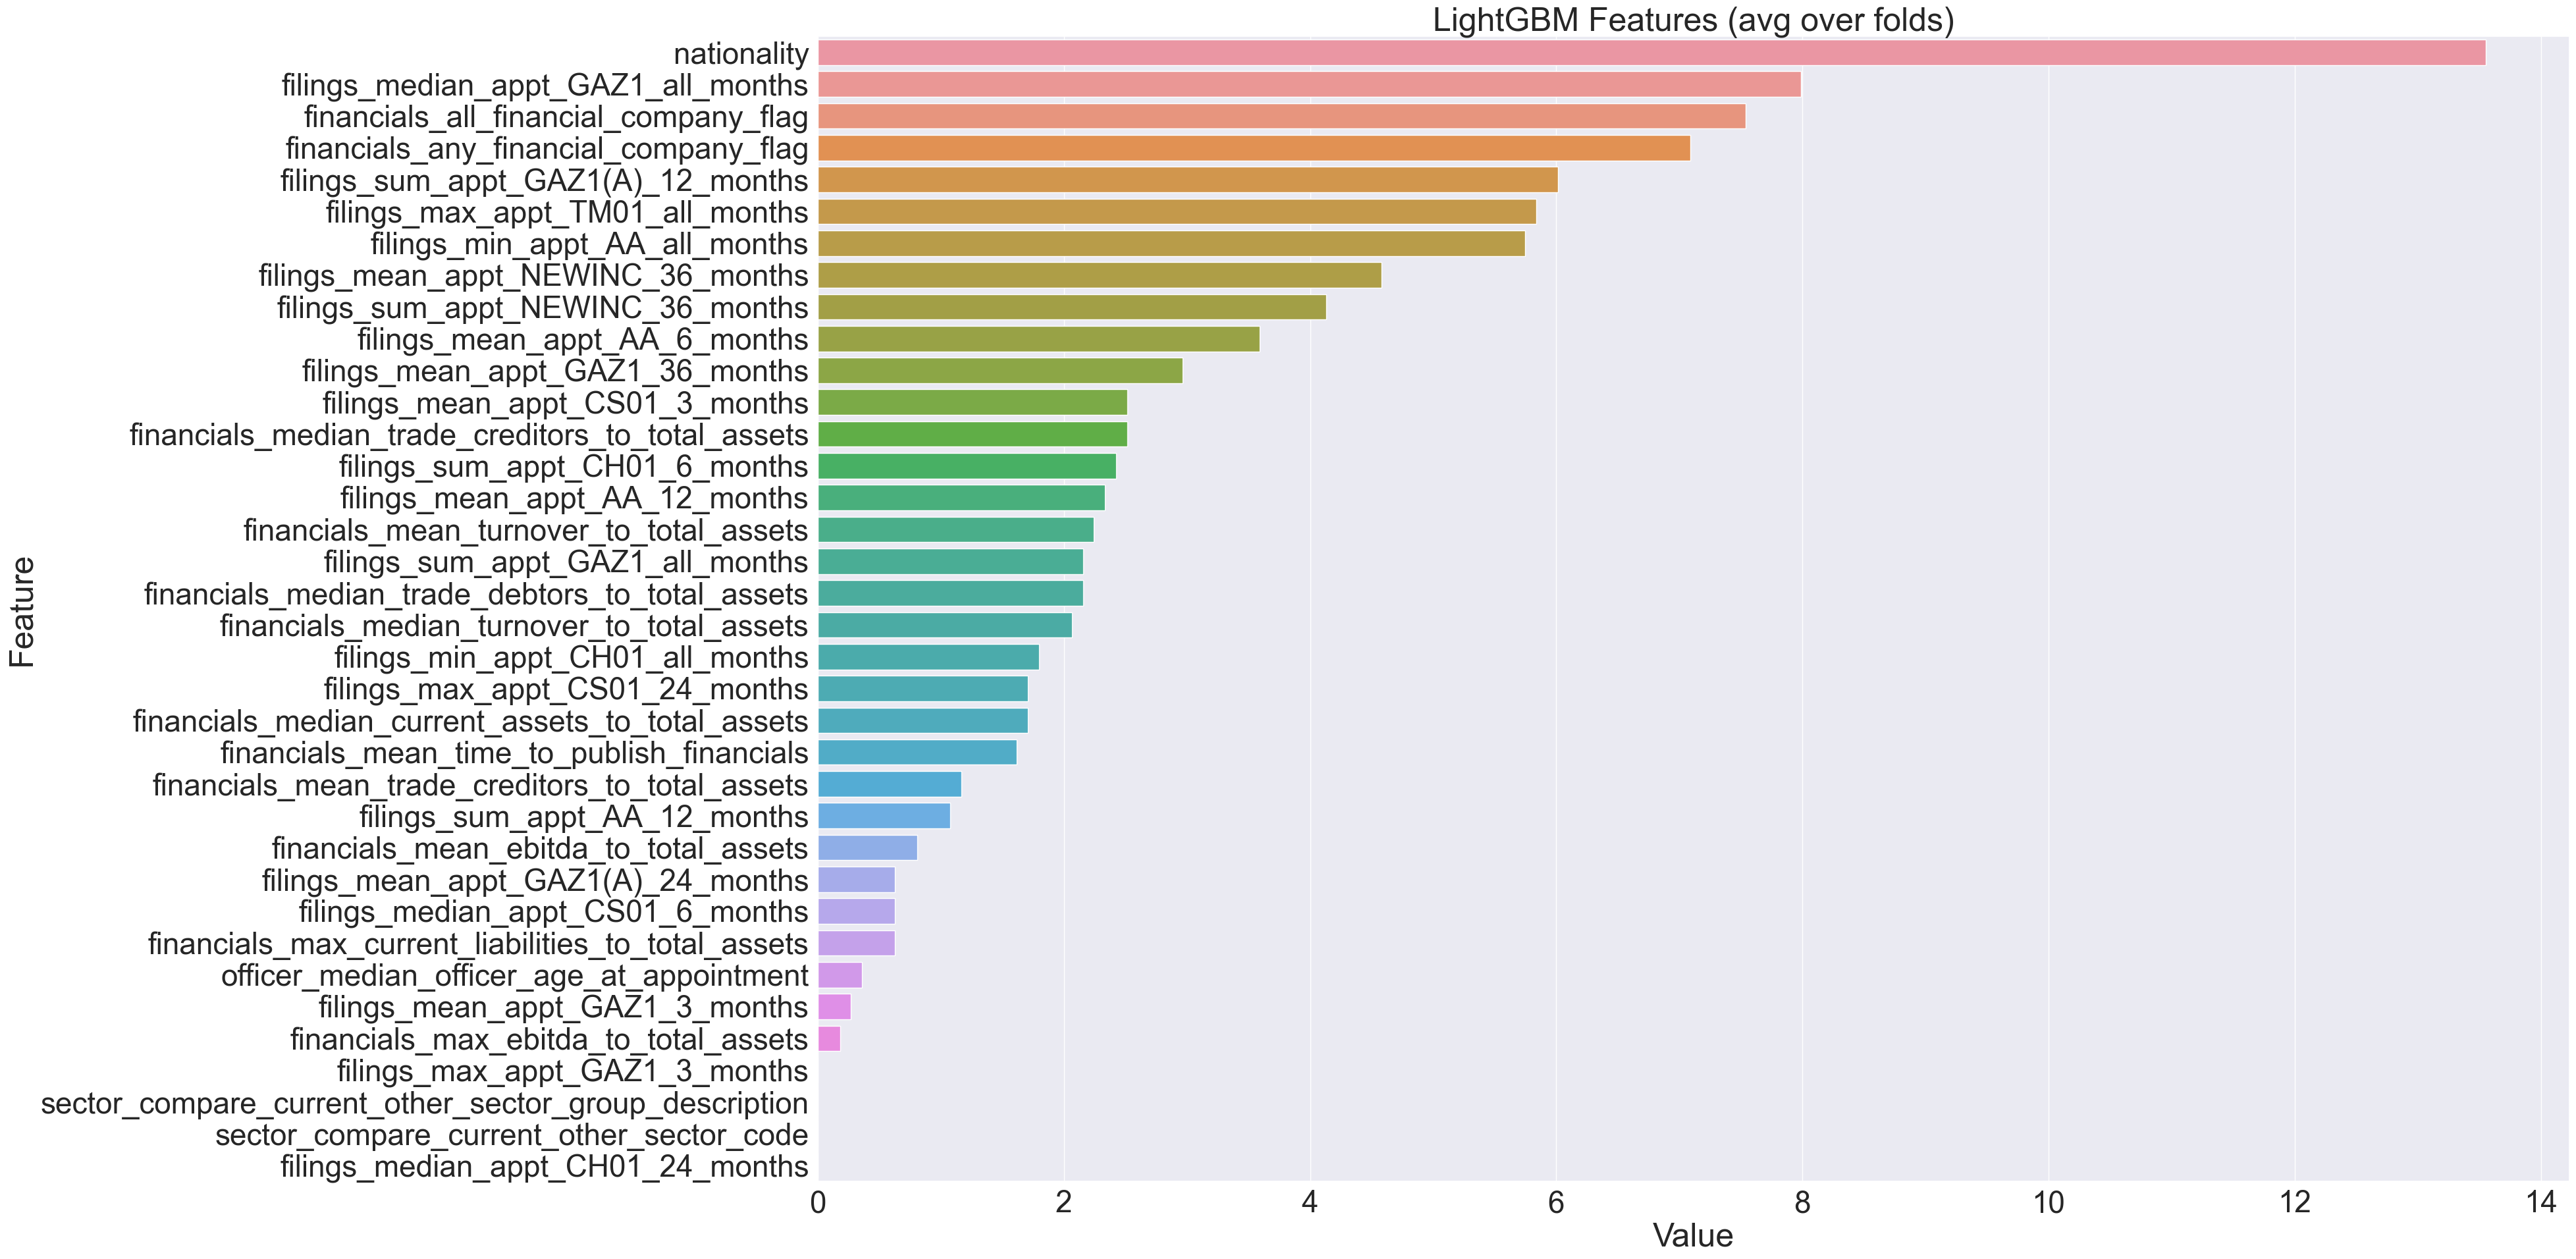

In [74]:
plotImp(clf_lgbm, val_data.data)

In [75]:
feat_for_test_set = list(train_data.data.columns)

In [76]:
test_data_feat_selected = test_data_wo_meta_cols[feat_for_test_set + ["label"]]
test_data_feat_selected_mapped , mapper_cat_test = encode_cat_by_dr(df= test_data_feat_selected, cat_cols_gini_analysis= ['nationality'])


In [77]:
test_data_feat_selected_mapped

nationality  filings_mean_appt_AA_12_months   
0              24                            0.34  \
1              24                            0.53   
2              24                            0.13   
3              24                            0.33   
4              24                            0.83   
...           ...                             ...   
1052           23                             NaN   
1053           24                            1.20   
1054           24                            0.00   
1055           24                            0.33   
1056           24                            1.00   

      filings_median_appt_GAZ1_all_months   
0                                     0.0  \
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
...                                   ...   
1052                                  0.0   
1053                                  0.0   
1054                                  0.0   
1055                                  0.0   
1056                                  0.0   

      financials_mean_time_to_publish_financials   
0                                         232.21  \
1                                         276.65   
2                                         210.95   
3                                         214.00   
4                                         287.60   
...                                          ...   
1052                                        0.00   
1053                                      169.40   
1054                                      211.00   
1055                                      332.80   
1056                                      195.00   

      filings_min_appt_AA_all_months  filings_mean_appt_NEWINC_36_months   
0                                0.0                                0.00  \
1                                1.0                                0.00   
2                                0.0                                0.00   
3                                0.0                                0.67   
4                                0.0                                0.33   
...                              ...                                 ...   
1052                             NaN                                 NaN   
1053                             6.0                                0.00   
1054                             3.0                                0.00   
1055                             0.0                                0.56   
1056                            32.0                                0.00   

      filings_sum_appt_NEWINC_36_months  filings_sum_appt_GAZ1_all_months   
0                                   0.0                              12.0  \
1                                   0.0                               9.0   
2                                   0.0                               1.0   
3                                   2.0                               0.0   
4                                   2.0                               0.0   
...                                 ...                               ...   
1052                                NaN                               0.0   
1053                                0.0                               0.0   
1054                                0.0                               0.0   
1055                                5.0                               1.0   
1056                                0.0                               0.0   

      financials_mean_turnover_to_total_assets   
0                                      0.04912  \
1                                      0.74955   
2                                      0.74225   
3                                      0.00000   
4                                      1.07467   
...                                        ...   
1052           

In [78]:
mapper_cat_test

{'nationality': {'AT': 0,
  'US': 1,
  'TR': 2,
  'SE': 3,
  'RO': 4,
  'PK': 5,
  'PH': 6,
  'NO': 7,
  'NL': 8,
  'MY': 9,
  'MX': 10,
  'LV': 11,
  'ZA': 12,
  'JP': 13,
  'LT': 14,
  'IL': 15,
  'IE': 16,
  'ES': 17,
  'DK': 18,
  'DE': 19,
  'CN': 20,
  'CH': 21,
  'BE': 22,
  'nan': 23,
  'GB': 24,
  'FR': 25,
  'IT': 26,
  'IN': 27,
  'AU': 28,
  'PL': 29,
  'RS': 30}}

In [79]:
X_test, y_test = create_target_and_estimators(df=test_data_feat_selected_mapped, target_name="label")

__Use mapper to convert X-test nationality column__

In [80]:
test_data = lightgbm.Dataset(data=X_test,
                             label=y_test,
                             feature_name=feats_selected,
                             categorical_feature=cat_feats_selected
                             )


In [81]:
print(f"train : {compute_dataset_gini(clf_lgbm, train_data.data, train_data.label)}")
print(f"val : {compute_dataset_gini(clf_lgbm, val_data.data, val_data.label)}")
print(f"test : {compute_dataset_gini(clf_lgbm, test_data.data, test_data.label)}")



[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.783143582365091e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.783143582365091e-08
[LightGBM] [Warning] bagging_fraction is set=0.5937960915783527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5937960915783527
[LightGBM] [Warning] lambda_l2 is set=0.00033180440271643555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033180440271643555
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=2.2406944870234016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2406944870234016
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.024664590725272956, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.024664590725272956
[LightGBM] [Wa

In [82]:
train_auc = (0.4001172696253348+1)/2
val_auc = (0.37800230208466545+1)/2 
test_auc = (0.30196430514745876+1)/2
print(f"train_auc: {train_auc}")
print(f"val_auc: {val_auc}")
print(f"test_auc: {test_auc}")

train_auc: 0.7000586348126674
val_auc: 0.6890011510423327
test_auc: 0.6509821525737294


In [83]:
import shap

In [84]:
explainer = shap.TreeExplainer(clf_lgbm)


In [85]:
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [86]:
shap_values

[array([[92.32831009, -0.16810142, 10.80656893, ...,  0.        ,
          0.24889851,  9.10159513],
        [97.43294695, -0.12970696,  8.76389994, ...,  0.        ,
          0.15537114,  5.9346158 ],
        [98.32337167, -0.22523641, 10.87038565, ...,  0.        ,
          0.50652741,  9.64275387],
        ...,
        [93.99439656, -1.18957052,  8.25536485, ...,  0.        ,
          0.51060102,  6.56036946],
        [96.46893031, -0.49678929, 10.40675097, ...,  0.        ,
          0.36003221, 10.10496212],
        [93.0476741 ,  2.43667826,  7.54486556, ...,  0.        ,
          0.51060102,  6.3683728 ]]),
 array([[-92.32831009,   0.16810142, -10.80656893, ...,   0.        ,
          -0.24889851,  -9.10159513],
        [-97.43294695,   0.12970696,  -8.76389994, ...,   0.        ,
          -0.15537114,  -5.9346158 ],
        [-98.32337167,   0.22523641, -10.87038565, ...,   0.        ,
          -0.50652741,  -9.64275387],
        ...,
        [-93.99439656,   1.18957052,

In [87]:
shap_values[1]

array([[-92.32831009,   0.16810142, -10.80656893, ...,   0.        ,
         -0.24889851,  -9.10159513],
       [-97.43294695,   0.12970696,  -8.76389994, ...,   0.        ,
         -0.15537114,  -5.9346158 ],
       [-98.32337167,   0.22523641, -10.87038565, ...,   0.        ,
         -0.50652741,  -9.64275387],
       ...,
       [-93.99439656,   1.18957052,  -8.25536485, ...,   0.        ,
         -0.51060102,  -6.56036946],
       [-96.46893031,   0.49678929, -10.40675097, ...,   0.        ,
         -0.36003221, -10.10496212],
       [-93.0476741 ,  -2.43667826,  -7.54486556, ...,   0.        ,
         -0.51060102,  -6.3683728 ]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


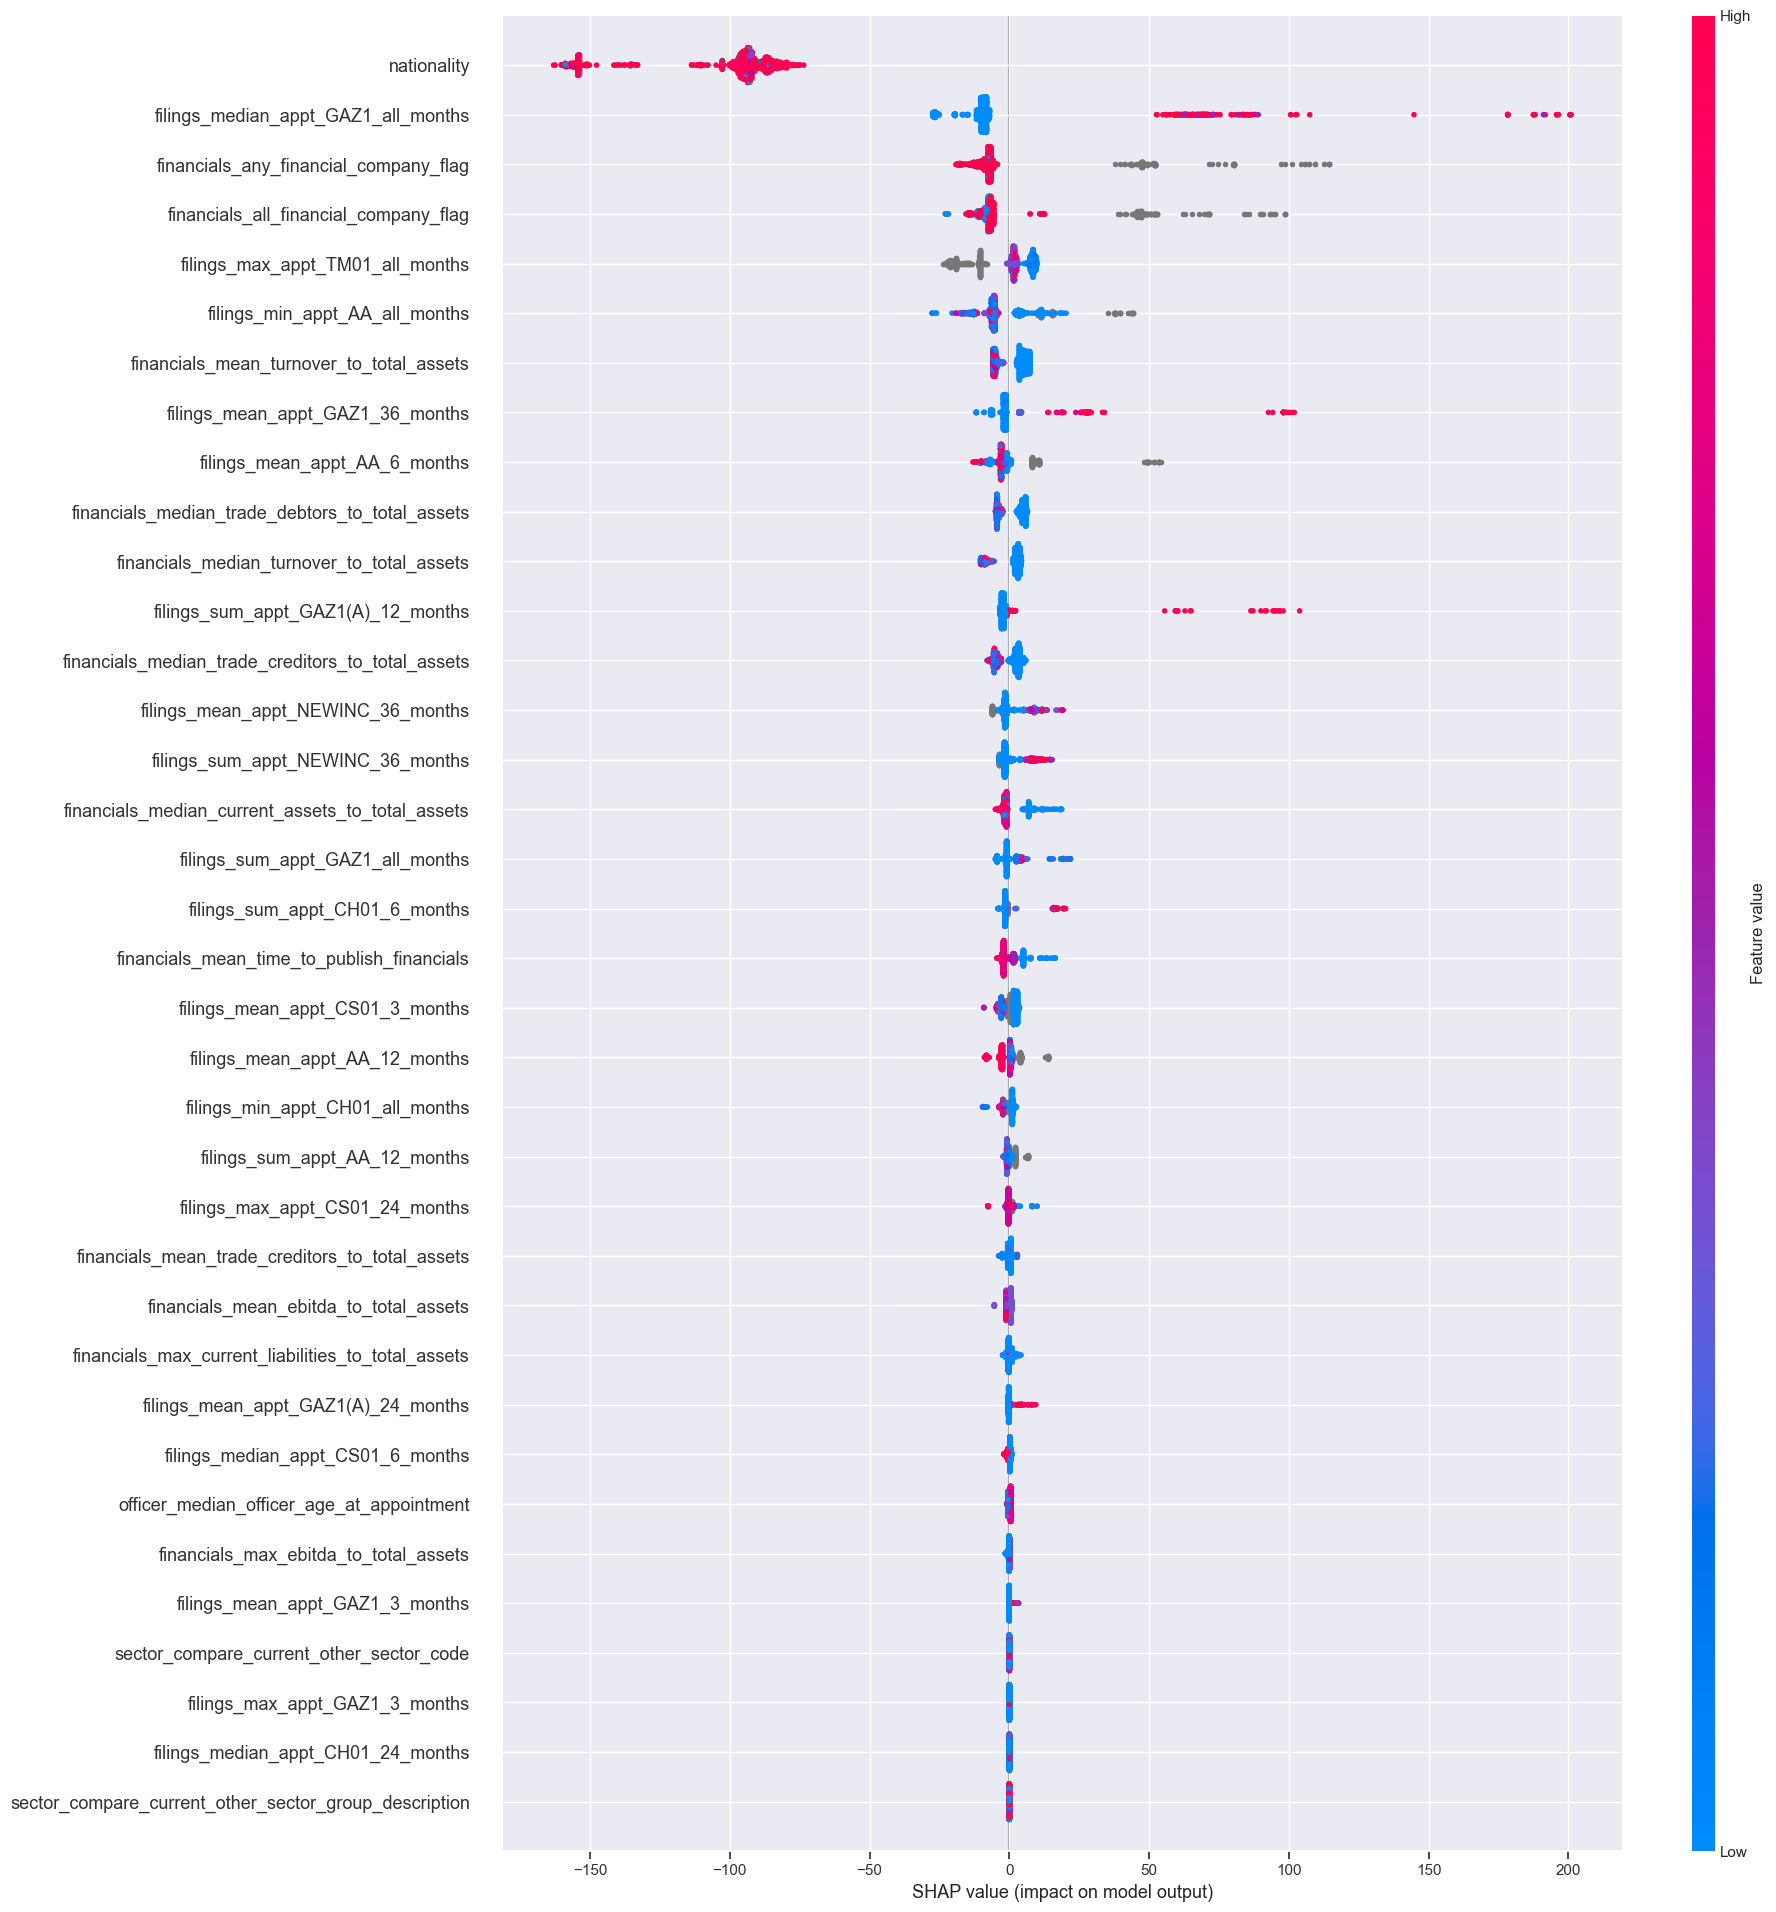

In [88]:
shap.summary_plot(shap_values[1], feature_names = list(X_test.columns), features = X_test, max_display= 40, plot_size=(20,20))


Let's interpret these SHAP values.<br>
We are looking at the SHAP values w.r.t. the bad officers (labelled as 1).<br>
Blue indicates a low value of the occurrence of the features in question and red indicates a high value.<br>
For example: for financials_all_company_financial_flag (can take a value of 0,1or null), an officer has a higher chance of being bad if they have no value associated with that variable indicating the company they worked at did not publish financials before the publication date and their incorporation date was greater than the observation date. It could also mean that there is no information about that company. On the other hand, a high value (of 1 which is the highest) could indicate that an officer has a lower chance of being bad due to the reason that they have published financials before the observation date.<br>
The second feature, filings_median_appt_GAZ1_all_months - This feature indicates that the higher the value of this feature, the more likely it is that the officer is a bad officer and vice-versa for an officer being a good one. This is in line with what we believe since GAZ1 filings are associated with insolvency (First Gazette notice for compulsory strike-off) and hence, the higer the value of the median number of appointments where the GAZ1 filing has been filed, the more likely the fact that the officer is bad.<br>
For filings_min_appt_AA_all_months: A lower value or not having any value indictaes a higher possibility of an officer being a bad officer while a higher number indicates a higher possibility of an officer being a good one. This is also in line with what is expected since AA filing type indicates annual accounts and a higher number being filed would indicate that the company is actually genuine.<br>
financials_mean_turnover_to_total_assets : A lower value of this feature indicates that the officer more likely to be a bad officer. This makes sense since bad companies will have a lower turnover to total asset ratio compared to good companies.<br>
Same for financials_median_turnover_to_total_assets.<br>
filings_sum_appt_NEWINC_36_months: A higher value of this feature indicates a higher chance of the officer being a bad officer. This makes sense because 

for sector code --> red will be 1 and 0 will be blue (not the same sector code).so this means that if an officer is good, they are most likely working in the same sector as their previous job.
grey indicates nan values.
so if an officer diesnt have the TM01 filings, more likely to be good.
so it has positive shap, so better likelihood of being bad.s

We are looking at the SHAP values of the bad officers. Red indicates a higher value of all_financial_company_flag and blue indicates a low value. A positive SHAP value indicates that the officer is more likely to be bad ans a negative SHAP value indicates that an officer is less likely to be bad.
From the above graph, we can see that based on nationality, most have negative SHAP values. There are many nationalities that have positive SHAP values 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.783143582365091e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.783143582365091e-08
[LightGBM] [Warning] bagging_fraction is set=0.5937960915783527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5937960915783527
[LightGBM] [Warning] lambda_l2 is set=0.00033180440271643555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033180440271643555
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=2.2406944870234016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2406944870234016
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.024664590725272956, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.024664590725272956
[LightGBM] [Wa

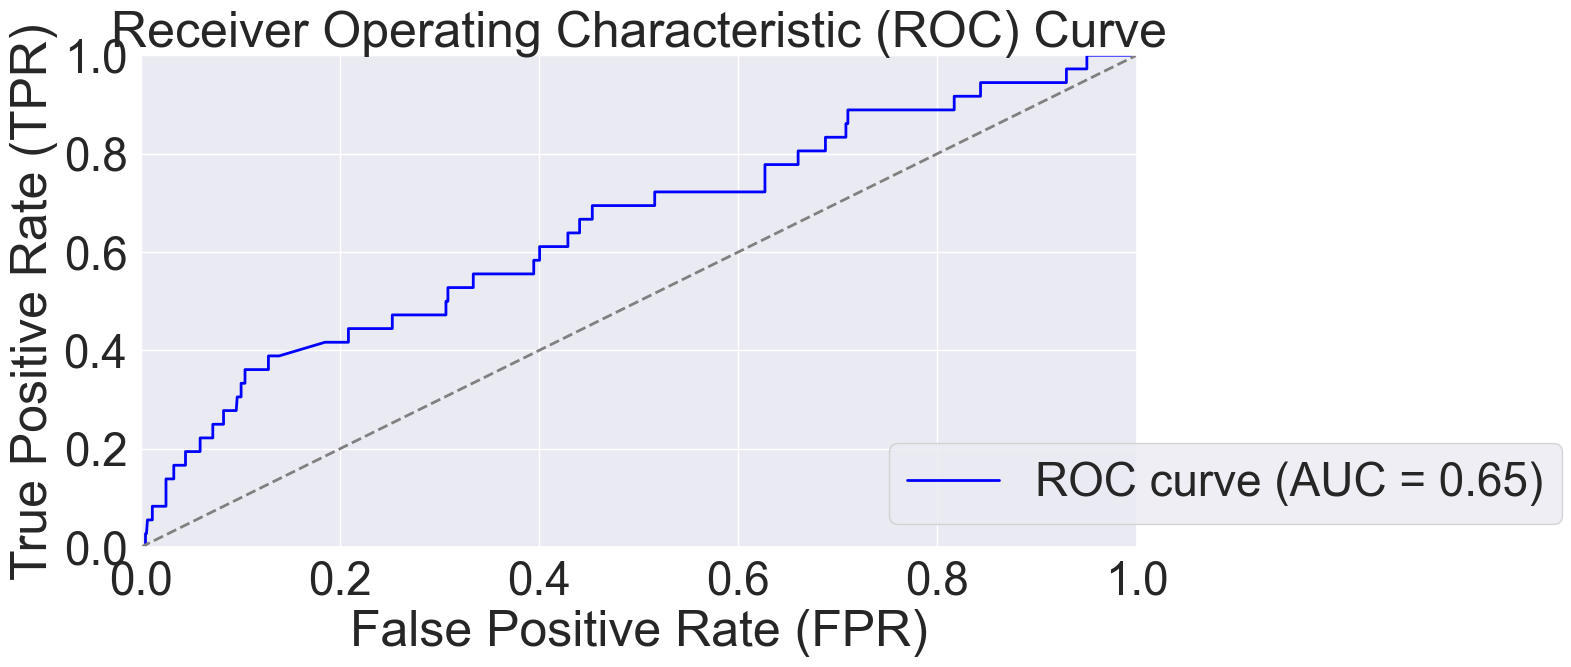

In [180]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have your trained model stored in 'model' and X_test and y_test are available

# Get predicted probabilities for the positive class (class 1)
y_pred_prob = clf_lgbm.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Set figure size
plt.figure(figsize=(12, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Adjust spacing between plot elements
plt.subplots_adjust(left=0.12, right=0.95, top=0.92, bottom=0.1)

# Increase font size for better readability
plt.rcParams['font.size'] = 2

# Move the legend outside the plot area to avoid overlap
plt.legend(loc='lower right', bbox_to_anchor=(1.45, 0))

#plt.show()


In [293]:
X_test

nationality  filings_mean_appt_AA_12_months   
0              24                            0.34  \
1              24                            0.53   
2              24                            0.13   
3              24                            0.33   
4              24                            0.83   
...           ...                             ...   
1052           23                             NaN   
1053           24                            1.20   
1054           24                            0.00   
1055           24                            0.33   
1056           24                            1.00   

      filings_median_appt_GAZ1_all_months   
0                                     0.0  \
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
...                                   ...   
1052                                  0.0   
1053                                  0.0   
1054                                  0.0   
1055                                  0.0   
1056                                  0.0   

      financials_mean_time_to_publish_financials   
0                                         232.21  \
1                                         276.65   
2                                         210.95   
3                                         214.00   
4                                         287.60   
...                                          ...   
1052                                        0.00   
1053                                      169.40   
1054                                      211.00   
1055                                      332.80   
1056                                      195.00   

      filings_min_appt_AA_all_months  filings_mean_appt_NEWINC_36_months   
0                                0.0                                0.00  \
1                                1.0                                0.00   
2                                0.0                                0.00   
3                                0.0                                0.67   
4                                0.0                                0.33   
...                              ...                                 ...   
1052                             NaN                                 NaN   
1053                             6.0                                0.00   
1054                             3.0                                0.00   
1055                             0.0                                0.56   
1056                            32.0                                0.00   

      filings_sum_appt_NEWINC_36_months  filings_sum_appt_GAZ1_all_months   
0                                   0.0                              12.0  \
1                                   0.0                               9.0   
2                                   0.0                               1.0   
3                                   2.0                               0.0   
4                                   2.0                               0.0   
...                                 ...                               ...   
1052                                NaN                               0.0   
1053                                0.0                               0.0   
1054                                0.0                               0.0   
1055                                5.0                               1.0   
1056                                0.0                               0.0   

      financials_mean_turnover_to_total_assets   
0                                      0.04912  \
1                                      0.74955   
2                                      0.74225   
3                                      0.00000   
4                                      1.07467   
...                                        ...   
1052           

In [303]:
y_pred = clf_lgbm.predict(X_test)
y_pred

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.783143582365091e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.783143582365091e-08
[LightGBM] [Warning] bagging_fraction is set=0.5937960915783527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5937960915783527
[LightGBM] [Warning] lambda_l2 is set=0.00033180440271643555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033180440271643555
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=2.2406944870234016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2406944870234016
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.024664590725272956, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.024664590725272956
[LightGBM] [Wa

1057

In [304]:
def calculate_precision(y_true, y_pred, positive_class=1):
    """
    Calculate precision given the true labels (y_true) and predicted labels (y_pred).
    The positive_class parameter specifies the class label that is considered positive.
    Precision measures the proportion of positive identifications that were actually correct.
    """
    true_positives = sum((y_true == positive_class) & (y_pred == positive_class))
    false_positives = sum((y_true != positive_class) & (y_pred == positive_class))
    
    if true_positives + false_positives == 0:
        return 0.0
    return true_positives / (true_positives + false_positives)

In [307]:
precision_rate_positive = calculate_precision(y_test, y_pred)
precision_rate_positive

0.18181818181818182

In [308]:
precision_rate_negative = calculate_precision(y_test, y_pred, positive_class=0)
precision_rate_negative

0.9674952198852772

In [309]:
def calculate_recall(y_true, y_pred, positive_class=1):
    """
    Calculate recall given the true labels (y_true) and predicted labels (y_pred).
    The positive_class parameter specifies the class label that is considered positive.
    Recall measures the proportion of actual positives that were identified correctly.
    """
    true_positives = sum((y_true == positive_class) & (y_pred == positive_class))
    false_negatives = sum((y_true == positive_class) & (y_pred != positive_class))
    
    if true_positives + false_negatives == 0:
        return 0.0
    return true_positives / (true_positives + false_negatives)

In [310]:
recall_positive = calculate_recall(y_test, y_pred, positive_class=1)
recall_positive

0.05555555555555555

In [311]:
recall_negative = calculate_recall(y_test, y_pred, positive_class=0)
recall_negative

0.9911851126346719

In [335]:
y_pred_prob = clf_lgbm.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.783143582365091e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.783143582365091e-08
[LightGBM] [Warning] bagging_fraction is set=0.5937960915783527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5937960915783527
[LightGBM] [Warning] lambda_l2 is set=0.00033180440271643555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033180440271643555
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=2.2406944870234016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2406944870234016
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.024664590725272956, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.024664590725272956
[LightGBM] [Wa

In [340]:
y_pred_prob

array([0., 0., 0., ..., 0., 0., 0.])

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [151]:
def custom_confusion_matrix(y_true, y_pred_probabilities, percentage_threshold):
    # Calculate the threshold based on the percentage of the positive class
    threshold = percentage_threshold
    
    # Convert predicted probabilities to binary predictions using the custom threshold
    y_pred = [1 if prob >= threshold else 0 for prob in y_pred_probabilities]
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    return cm

In [152]:
y_pred_probabilities = clf_lgbm.predict_proba(X_test)[:, 1]  # Second column corresponds to positive class probabilities
y_pred_probabilities

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=9.783143582365091e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.783143582365091e-08
[LightGBM] [Warning] bagging_fraction is set=0.5937960915783527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5937960915783527
[LightGBM] [Warning] lambda_l2 is set=0.00033180440271643555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033180440271643555
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=2.2406944870234016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2406944870234016
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.024664590725272956, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.024664590725272956
[LightGBM] [Wa

array([0.05432411, 0.07176776, 0.05888778, ..., 0.05159266, 0.06075523,
       0.05957682])

In [153]:
percentage_threshold = 0.06 #Bad rate

In [154]:
cm = custom_confusion_matrix(y_test, y_pred_probabilities, percentage_threshold)
cm
#So actual good --> 540
#actual bad --> 25
#actually good but put as bad --> 481
# Add bad bad but put as good 11

array([[540, 481],
       [ 11,  25]])

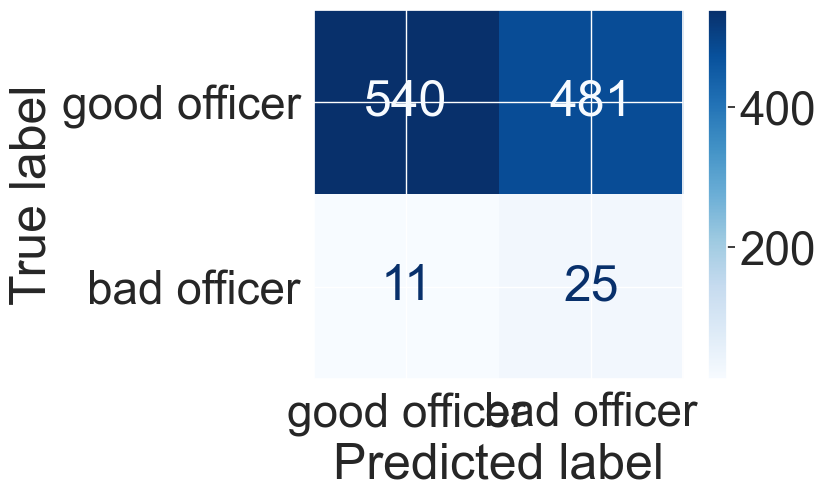

In [155]:
labels = ["good officer", "bad officer"]
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [147]:
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_positive = cm[1][1]

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.04940711462450593
Recall: 0.6944444444444444


The results you provided for precision and recall indicate the following:

1. **Precision**: Precision is the ratio of correctly predicted positive instances to the total predicted positive instances. In your case, the precision is approximately 0.0494 or about 4.94%. This means that out of the instances that your model predicted as positive (both true positives and false positives), only about 4.94% of them are actually true positive cases. In other words, the positive predictions made by your model are not very accurate.

2. **Recall**: Recall, also known as sensitivity or true positive rate, is the ratio of correctly predicted positive instances to the total actual positive instances. The recall value you have is approximately 0.6944 or about 69.44%. This means that your model is able to correctly identify about 69.44% of the actual positive instances in the dataset. In other words, your model is better at capturing the true positive cases, but it might also be classifying some negative cases as positive (as indicated by the relatively low precision).

A high recall indicates that the model is good at identifying positive cases, while a high precision indicates that when the model predicts a positive case, it is likely to be correct. In your case, the model seems to have higher recall but lower precision, which might suggest that it's capturing a good portion of actual positive cases but also generating a fair number of false positives.

In [148]:
f1_score = 2 * (precision * recall) / (precision + recall)

f1_score

0.09225092250922509

Talk about the fact that when you increase the threshold from 0.06 to 0.5, almost everything gets assigned to the majority (0) class and therefore, it is necessary to use the threshold of 0.06.